# Garmin daily reports and activities 
> An analysis of sports activities and wellness reports.

- toc: false
- badges: false
- comments: true
- use_plotly: true
- categories: [jupyter, garmin, monitoring]

I have a Garmin watch since 2012 (I have already changed 3 times) and the latest, Forerunner 735XT, stores heart rate, number of steps, sleep times... every day. The Garmin [dashboard](https://connect.garmin.com/modern/) is pretty cool but it does not allow to visualize data from (very) long period so, in this notebook, we will have a look on how my wellness and my sport activities have evolved since 2012. 

## Downloading Garmin data

Another limitation of Garmin dashboard is the number of reports/activities that can be exported *via* its interface. Bascially, you have to scroll down to get all the activities since only 25 activities are initially loaded. You can then export the result as `csv` file but you don't have, for instance, the GPS track. There are different ways to download your Garmin data. For instance, you can download the `FIT` files directly from your Garmin watch. You can also use external programs that will grab your data from Garmin websites. I've found at least two `python` programs:
1. [garmin-connect-export](https://github.com/pe-st/garmin-connect-export) will **only** download your Garmin activities and make a nice `csv` report of all your practices. If you don't have or don't care about your daily tracks, this program is largely enough.
2. [GarminDB](https://github.com/tcgoetz/GarminDB) is more complete since it downloads everything. The information is then store within `sqlite` databases that can be pretty huge (few 100 Mb in my case).

Since I don't want to analyse this data every day, I finally choose another way to retrieve the data from Garmin website. I used the official [way](https://www.garmin.com/en-US/account/datamanagement/exportdata/). After unzipping the archive everything gets messed in a nested hierarchical tree with a bunch of empty directories. I "flatten" the archive to only extract the relevant files by doing

```shell
unzip -j -o garmin_data.zip -d data
```

Now we can start to dig into the different files. In this post, I will only read the `json` files to get a good overview of my sports and daily activities. I will not parse the `FIT` files but you can use the [Software Development Kit](https://developer.garmin.com/fit/overview/) made by Garmin and for instance, you can convert your `FIT` files into `csv` by doing

```shell
java -jar FitCSVTool.jar -b activity.fit activity.csv
```
You can also use `python` parser such as [`python-fitparse`](https://github.com/dtcooper/python-fitparse) (there might be other ones). 

## Preamble & plot settings

We will mainly use [`pandas`](https://pandas.pydata.org) library to handle the data files and [`plotly`](https://plotly.com/python) + [`seaborn`](https://seaborn.pydata.org) libraries for plotting purposes.

In [1]:
import glob

import pandas as pd
import numpy as np

import seaborn as sns

def get_plot_settings(kind="scatter", opacity=0.5, trendline="lowess", frac=0.1):
    settings = dict(template="seaborn", kind=kind, opacity=opacity)

    if kind == "scatter":
        settings.update(
            {
                "trendline": trendline,
                "trendline_options": dict(frac=frac) if trendline == "lowess" else None,
            }
        )
    return settings


pd.options.plotting.backend = "plotly"
sns.set_theme(style="whitegrid")

## Wellness

We will start by looking into wellness information such as the resting heart rate or the number of steps per day. These informations are stored within `UDSFile*.json` files. We will also merge these data with the sleep time informations whose are stored within `*sleepData.json` files. Let's concatenate all of them after haing indexed them by calendar date.

In [2]:
left = pd.concat([pd.read_json(fn) for fn in glob.glob("./data/UDS*.json")])
left.set_index(
    pd.to_datetime(left["restingHeartRateTimestamp"]).dt.normalize().rename("date"),
    inplace=True,
)
right = pd.concat([pd.read_json(fn) for fn in glob.glob("./data/*sleep*.json")])
right.set_index(
    pd.to_datetime(right["calendarDate"]).dt.normalize().rename("date"), inplace=True
)
df = pd.merge(left, right, left_index=True, right_index=True)

### Heart rate monitoring

First, we will have a look to heart rates. 

In [3]:
fields = ["restingHeartRate", "minHeartRate", "maxHeartRate"]
df[fields].describe()

restingHeartRate  minHeartRate  maxHeartRate
count       1136.000000   1136.000000   1136.000000
mean          50.309859     43.418134    141.169894
std            2.688027      3.590539     23.592656
min           37.000000     30.000000     87.000000
25%           48.000000     41.000000    123.000000
50%           50.000000     44.000000    138.000000
75%           52.000000     46.000000    160.000000
max           58.000000     53.000000    204.000000

We will plot the min/max and resting heart rate versus the time. To better follow the time variation of each curves, I have also added a `lowess` (Locally Weighted Scatterplot Smoothing) trendline.

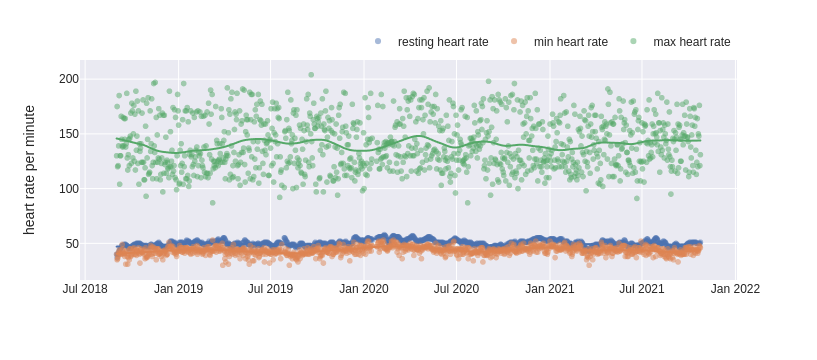

In [4]:
df[fields].rename(
    columns={
        field: "".join(f" {c.lower()}" if c.isupper() else c for c in field)
        for field in fields
    }
).plot(
    labels={"value": "heart rate per minute", "variable": "", "date": ""},
    **get_plot_settings(),
).update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

Basically, during summer and beginning of autumn when I do a lot of sports, the resting heart as well as the minimum heart rate (both completely correlated) decrease and then increase during the winter time. We will see latter if we can correlate these time variations with the number of activities per day.

### Number of steps per day

Let's now have a look to the number of steps done by day. Garmin dashboard allow to see them but not on period larger than 1 year. Here we also add the daily step goal for comparison purpose (orange curve).

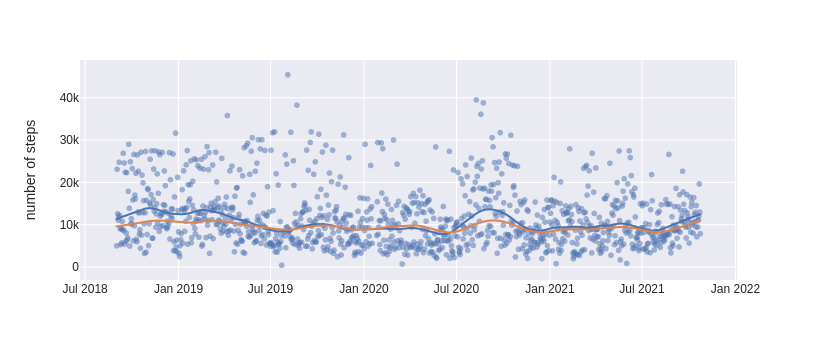

In [5]:
df[["totalSteps", "dailyStepGoal"]].plot(
    labels={"date": "", "value": "number of steps"}, **get_plot_settings()
).update_layout(showlegend=False).update_traces(
    selector=-2, opacity=0, hovertemplate=None, hoverinfo="skip"
)

Just like the resting heart rate, we clearly see a bump in the 2020 summer when I actually did a lot of sport activities especially trail competitions. The software which updates the daily step goal given the number of steps achieved is pretty good in the sense that I have overcome the goal almost 50% of the time

In [6]:
(df.totalSteps > df.dailyStepGoal).sum()/len(df.dailyStepGoal)

0.5369718309859155

### Sleep times

I also keep my watch during the night to monitor my sleep times. The total amount of sleep time is not provided, so let's add it by summing the different sleep status : awake, light and deep sleep

In [7]:
fields = ["deepSleepSeconds", "lightSleepSeconds", "awakeSleepSeconds", "totalSleepSeconds"]
df["totalSleepSeconds"] = df[fields[:-1]].dropna().sum(axis=1)
df[fields].div(3600).describe()

deepSleepSeconds  lightSleepSeconds  awakeSleepSeconds  \
count       1129.000000        1129.000000        1129.000000   
mean           2.322601           4.712002           0.166800   
std            0.724116           1.028293           0.187822   
min            0.000000           0.000000           0.000000   
25%            1.883333           4.100000           0.066667   
50%            2.300000           4.716667           0.116667   
75%            2.766667           5.400000           0.216667   
max            6.166667           8.150000           1.716667   

       totalSleepSeconds  
count        1129.000000  
mean            7.201402  
std             1.201655  
min             0.000000  
25%             6.583333  
50%             7.266667  
75%             7.950000  
max            10.333333

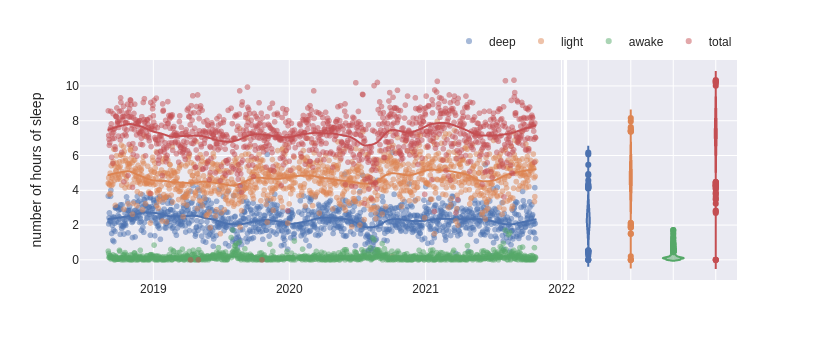

In [8]:
df[fields].div(3600).rename(
    columns={field: field.replace("SleepSeconds", "") for field in fields}
).plot(
    labels={"value": "number of hours of sleep", "variable": "", "date": ""},
    **get_plot_settings(),
    marginal_y="violin"
).update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

Interestingly, there are 3 days for which I do not sleep at all. Let's have a look on what's going on 

In [9]:
df[df["totalSleepSeconds"] == 0][["sleepWindowConfirmationType"]]

sleepWindowConfirmationType
date                                  
2019-04-11                   OFF_WRIST
2019-05-02                   OFF_WRIST
2019-10-20                   OFF_WRIST

As far as I can understand, on a total of 1129 nights, I have only slept 3 nights without my watch. I'm a bit surprised by how low this number is but it is what it is. Finally let's have at the total number of hours I sleep per day and let's compare it to the mean and standard deviation 

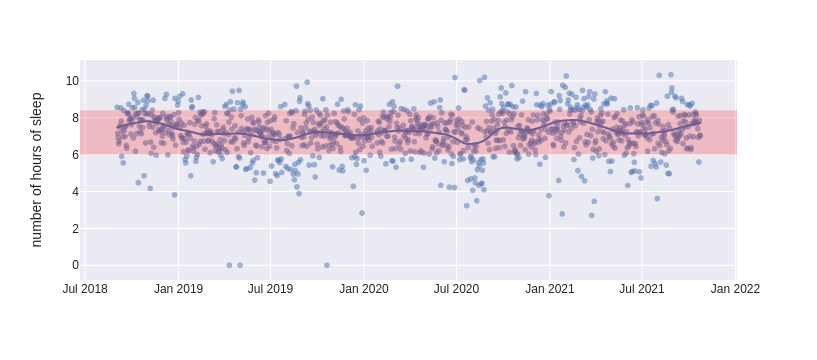

In [10]:
total_sleep_hours = df.totalSleepSeconds.div(3600)
mean, std = total_sleep_hours.mean(), total_sleep_hours.std()
total_sleep_hours.plot(
    labels={"value": "number of hours of sleep", "variable": "", "date": ""},
    **get_plot_settings(),
).update_layout(showlegend=False).add_hrect(
    y0=mean - std, y1=mean + std, line_width=0, fillcolor="red", opacity=0.2
)

In [11]:
(total_sleep_hours > mean).sum()/len(total_sleep_hours)

0.5211267605633803

In [12]:
((total_sleep_hours - mean).abs() < std).sum()/len(total_sleep_hours)

0.7183098591549296

As the violin plot shown before, the distribution is quite gaussian with 71% of the nights within mean ± 1σ (68% for normal distribution). 